# 2. Cleanup and renumber PDB files

1. we would like to renumber antibody chain from `CHOTHIA` antibody numbering scheme to the incremental one, i.e. each residue will be assigned unique number, starting with 1
2. residues that are located in the constant region will be filtered out
3. only one pair of HL chains will be kept; based on file metadata
4. all files that do not contain suitable HL pair will be filtered out

We perform these steps using `cleanup_mAb_renumberer.py` script. The aim is to make data as much convenient for subsequent analyses and experiment as possible.

Example script usage:

> `python cleanup_mAb_renumberer.py input_dir/1xnx.pdb chothia output_dir/1xnx.pdb` 

___

## Setup

In [22]:
import sys; sys.path.append('../..')
import math
import os
import pickle
import subprocess
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

import bin.params as p
import bin.utils as u
import _file_paths as fp
import _renumber

sns.set_theme()
sns.set(rc = {'figure.figsize':(12,6)})

In [23]:
# July2024
DATASET = 'test_new_234'
RENUMBER_STATUS_PATH = f'{p.DATA_DIR}/csv/renumber_status_July2024.csv' # July2024
INPUT_PDB_DIR = f'{p.DATA_DIR}/pdb/all_structures_2024/{p.INITIAL_NUMBERING_SCHEME}' # july2024
INCREMENTAL_SCHEME_DIR = f'{p.DATA_DIR}/pdb/incrementalJuly2024'

# IB july2024
RENUMBER_STATUS_PATH = f'{p.DATA_DIR}/csv/renumber_status_IBJuly2024.csv' # July2024
INPUT_PDB_DIR = f'{p.DATA_DIR}/pdb/immunobuilderJuly2024_aho' # july2024
INCREMENTAL_SCHEME_DIR = f'{p.DATA_DIR}/pdb/incrementalIBJuly2024'
RENUMBER_HISTOGRAM_PATH = f"{p.DATA_DIR}/png/renumber_status_barplotIBJuly2024.png"

# old
DATASET = 'test'
RENUMBER_STATUS_PATH = f'{p.DATA_DIR}/csv/renumber_status_{DATASET}.csv' 
INPUT_PDB_DIR = f'{p.DATA_DIR}/pdb/all_structures_2024/{p.INITIAL_NUMBERING_SCHEME}'
INCREMENTAL_SCHEME_DIR = f'{p.DATA_DIR}/pdb/incremental_{DATASET}'
RENUMBER_HISTOGRAM_PATH = f"{p.DATA_DIR}/png/renumber_status_barplot_{DATASET}.png"

(RENUMBER_STATUS_PATH, INPUT_PDB_DIR, INCREMENTAL_SCHEME_DIR, RENUMBER_HISTOGRAM_PATH)

('../../data/csv/renumber_status_test.csv',
 '../../data/pdb/all_structures_2024/chothia',
 '../../data/pdb/incremental_test',
 '../../data/png/renumber_status_barplot_test.png')

**Create the directory to store renumbered PDBs in:**

In [24]:
command = f'mkdir -p {INCREMENTAL_SCHEME_DIR}'
print('command:', command)
! $command

command: mkdir -p ../../data/pdb/incremental_test


---

## Renumber

**Load the renumbering-status dataframe so we can continue with renumbering 
without losing the progress that has been achieved already:**

In [29]:
old_renumber_status_df = pd.read_csv(f'{p.DATA_DIR}/csv/renumber_status_July2024.csv', index_col=0)
print('total number of structures:', old_renumber_status_df.shape[0])
old_renumber_status_df['status'].value_counts()

total number of structures: 1524


ok                    888
hl-not-paired         373
single-chain          254
chain-not-numbered      7
other-error             1
alignment-failed        1
Name: status, dtype: int64

In [25]:
old_renumber_status_df, renumbered_structures = None, set()

if os.path.exists(RENUMBER_STATUS_PATH):
    print('loading renumber status from:', RENUMBER_STATUS_PATH)
    old_renumber_status_df = pd.read_csv(RENUMBER_STATUS_PATH, index_col=0)
    renumbered_structures = set(old_renumber_status_df['structure_code'])
else:
    print('generating status anew')

generating status anew


In [ ]:
print('total number of structures:', old_renumber_status_df)
old_renumber_status_df['status'].value_counts()

In [21]:
if DATASET == 'test':
    fasta_test_df, sasa_test_df = u.load_dataset('test', chains='L')
    assert fasta_test_df.shape == sasa_test_df.shape
    structures = set(ch[:4] for ch in fasta_test_df['Id'])
    print('input PDB dir path:', INPUT_PDB_DIR)
    filenames = [x for x in os.listdir(INPUT_PDB_DIR) if x.endswith('.pdb') and x[:4].upper() in structures]
    print('filtered filenames length:', len(filenames))
    assert fasta_test_df.shape[0] == len(filenames)

load_dataset: test, metadata file path: ../../data/csv/metadata/metadata_L.csv, chains: L, shape: (643, 19)
load_dataset: test, X file path: ../../data/csv/fasta_aligned_cleaned/fasta_aho_L.csv, chains: L, shape: (643, 154)
load_dataset: test, Y file path: ../../data/csv/sasa_aligned/sasa_L.csv, chains: L, shape: (643, 154)
input PDB dir path: ../../data/pdb/all_structures_2024/chothia
filtered filenames length: 32


AssertionError: 

**Do the actual renumbering:**

In [16]:
filenames = [x for x in os.listdir(INPUT_PDB_DIR) if x.endswith('.pdb')]

In [38]:
new_renumber_status_data = defaultdict(list)
for filename in tqdm(filenames, desc='Cleaning raw PDB data...'):
    structure_code = filename.split('.')[0]
    if not filename.endswith('.pdb'): continue
    if old_renumber_status_df is not None and structure_code in renumbered_structures:
        # no need to process the structure again, processed already
        continue
       
    # renumber
    result = _renumber.renumber(
        input_dir_path=INPUT_PDB_DIR, 
        filename=filename,
        output_dir_path=INCREMENTAL_SCHEME_DIR,
        final_numbering_scheme='incremental')
    
    # add to the results structure
    new_renumber_status_data['structure_code'].append(result['structure_code'])
    new_renumber_status_data['status'].append(result['status'])

Cleaning raw PDB data...:   0%|          | 0/881 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
new_renumber_status_data

defaultdict(list,
            {'structure_code': ['8QH0',
              '8DS5',
              '8HEC',
              '7UL1',
              '8XN9',
              '7UVI',
              '8OXX',
              '8DIM',
              '8DKE',
              '8SDG',
              '8HPU',
              '7XDA',
              '8E8Y',
              '8UKY',
              '8U08',
              '8IUY',
              '7QT3',
              '7Z3W',
              '7THO',
              '8IB1',
              '8BSE',
              '8GAS',
              '7XRZ',
              '8EUU',
              '7TJQ',
              '7QT2',
              '7ZQT',
              '8GY5',
              '8E8X',
              '8SDF',
              '8CBZ',
              '7WCK',
              '8DF5',
              '8OXY',
              '7UVH',
              '7U64',
              '7RE9',
              '8A99',
              '8CT6',
              '7UL0',
              '8TUI',
              '8HEB',
              '8QH1',
              '7WW

**Store the results to `.csv` file:**

In [24]:
new_renumber_status_df = pd.DataFrame(new_renumber_status_data)

if old_renumber_status_df is not None:
    total_renumber_status_df = pd.concat([old_renumber_status_df, new_renumber_status_df]).reset_index()
    print('concating...')
else: 
    total_renumber_status_df = new_renumber_status_df

total_renumber_status_df = total_renumber_status_df.drop(columns=['level_0', 'index'], errors='ignore')
print('total_renumber_status_df.shape:', total_renumber_status_df.shape)
total_renumber_status_df.to_csv(RENUMBER_STATUS_PATH)

total_renumber_status_df.shape: (880, 2)


## Sanity check

Does the number of files we have in `data/pdb/incremental` directory match the number of `ok` records in `renumber_status` dataframe?

**1. Number of files in the directory:**

In [29]:
ls -l ../../data/pdb/incrementalIBJuly2024

total 0


In [28]:
# `tail -n +2` will skip the first line of `ls` output (that one is just a summary line)
print(INCREMENTAL_SCHEME_DIR)
command = f"ls -l {INCREMENTAL_SCHEME_DIR} | tail -n +2 | wc -l"
! $command

../../data/pdb/incrementalIBJuly2024
       0


**2. Number of `ok` records in the dataframe:**

In [38]:
ok_records = total_renumber_status_df[ total_renumber_status_df['status'] == 'ok' ]
ok_records.shape[0]

888

**If the counts do not match, which files are missing in the directory?**

In [39]:
dataframe_structures = set(ok_records['structure_code'].values)
directory_structures = set(f[:-4] for f in os.listdir(INCREMENTAL_SCHEME_DIR) if f.endswith('.pdb'))
dataframe_structures.difference(directory_structures), directory_structures.difference(dataframe_structures)

(set(), set())

**If none are missing, then it is problem with dataframe duplicates, drop them:**


In [41]:
new_total_df = total_renumber_status_df.drop_duplicates()
new_total_df.shape

(1524, 2)

**Save the corrected dataframe:**

In [42]:
new_total_df.to_csv(RENUMBER_STATUS_PATH)

---

## Visualize the renumbering results

**Show what the renumbering status DF looks like:**

In [43]:
total_renumber_status_df = pd.read_csv(RENUMBER_STATUS_PATH, index_col=0)
total_renumber_status_df.head(n=3)

,structure_code,status
0,7um5,single-chain
1,8qh0,ok
2,8spu,single-chain


**Visualize:** 

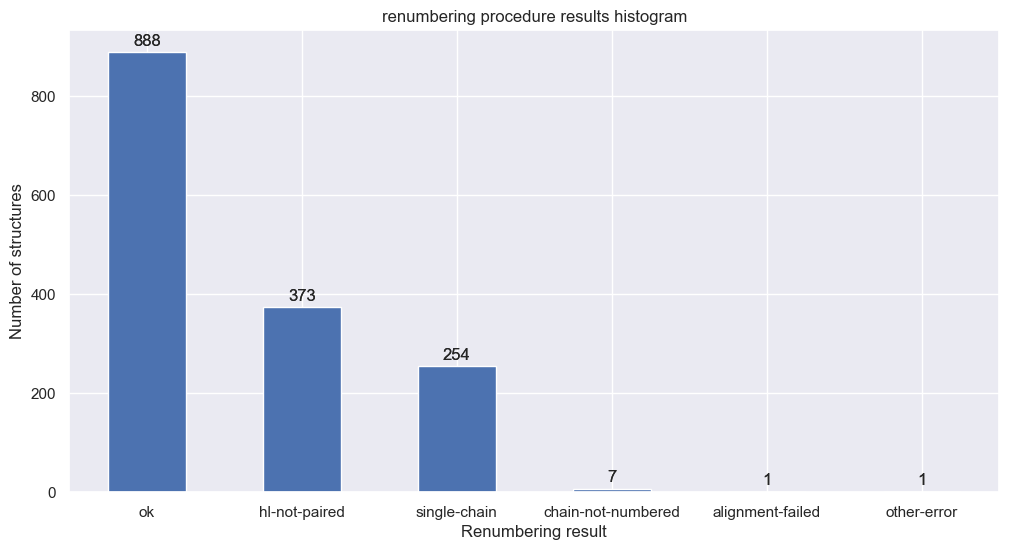

In [44]:
status_counts = total_renumber_status_df.groupby('status').count()
status_counts.columns = ['structure_count']
status_counts.sort_values(by='structure_count', ascending=False, inplace=True)
sc_plot = status_counts.plot.bar(legend=False)
u.show_barplot_values(sc_plot)
u.annotate_plot(plot=sc_plot,
    show_bar_values = True, bar_decimals = 0, 
    title=f'renumbering procedure results histogram', 
    xlabel='Renumbering result',
    ylabel='Number of structures')
sc_plot.figure.savefig(RENUMBER_HISTOGRAM_PATH)

In [ ]:
# remove the structures that do not have sidechains
# add missing hydrogens
# compute number of missing atoms